In [41]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import hdbscan

⏳ Chargement des données...
✅ Données chargées avec succès !
⚙️ Nettoyage des valeurs infinies et NaN...
✅ Nettoyage terminé !
🔧 Suppression des valeurs aberrantes...
✅ Valeurs aberrantes traitées !
🔄 Normalisation des données...
✅ Normalisation terminée !
📊 Application de l'ACP...
✅ ACP terminée !
📈 Visualisation des contributions des features...


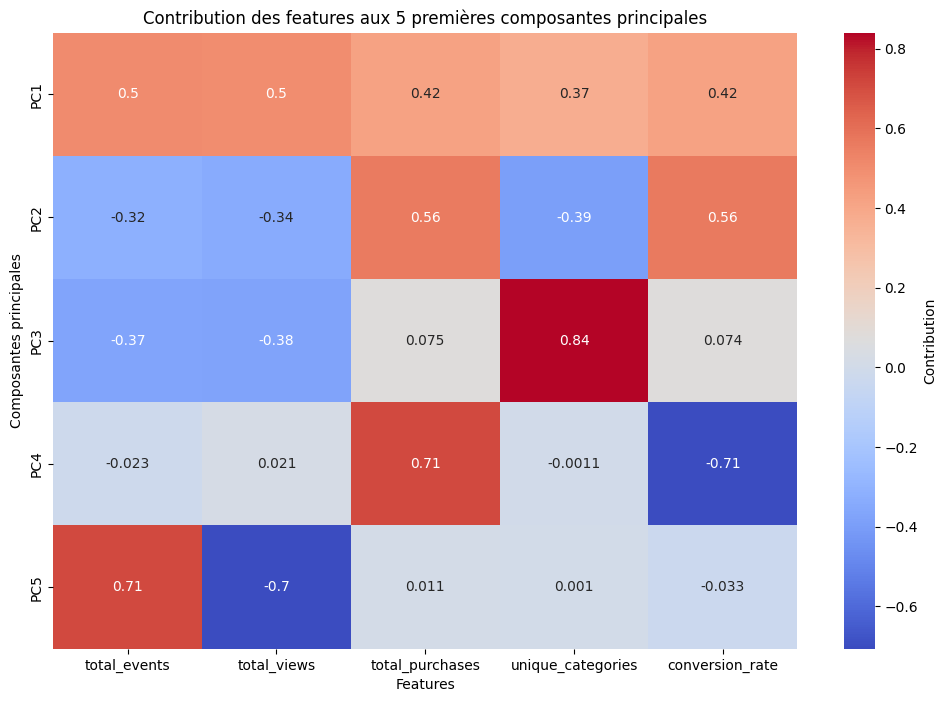

In [32]:
# 📂 Charger les données avec Dask (optimisation mémoire)
file_path = "../data/output/user_features.parquet"
print("⏳ Chargement des données...")
df_dask = dd.read_parquet(file_path)
df = df_dask.compute()  # Convertir en Pandas après chargement
print("✅ Données chargées avec succès !")

# 📌 Sélection des features pertinentes pour l'ACP
features = ["total_events", "total_views", "total_purchases", "unique_categories", "conversion_rate"]
df_pca = df[features].copy()

# ✅ Remplacement des valeurs infinies et NaN
print("⚙️ Nettoyage des valeurs infinies et NaN...")
df_pca.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pca.fillna(0, inplace=True)
print("✅ Nettoyage terminé !")

# ✅ Suppression des valeurs aberrantes (limite au 99e percentile)
print("🔧 Suppression des valeurs aberrantes...")
for col in features:
    upper_limit = df_pca[col].quantile(0.90)
    df_pca[col] = np.clip(df_pca[col], 0, upper_limit)
print("✅ Valeurs aberrantes traitées !")

# 📌 Normalisation des données
print("🔄 Normalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)
print("✅ Normalisation terminée !")

# 🔍 Application de l'ACP
print("📊 Application de l'ACP...")
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("✅ ACP terminée !")

# 📈 Visualisation des contributions des features aux composantes principales
print("📈 Visualisation des contributions des features...")

# Création d'un DataFrame pour les contributions
contributions = pd.DataFrame(pca.components_, columns=features, index=[f"PC{i+1}" for i in range(5)])

# Tracé de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contributions, annot=True, cmap="coolwarm", cbar_kws={'label': 'Contribution'})
plt.title("Contribution des features aux 5 premières composantes principales")
plt.xlabel("Features")
plt.ylabel("Composantes principales")
plt.show()


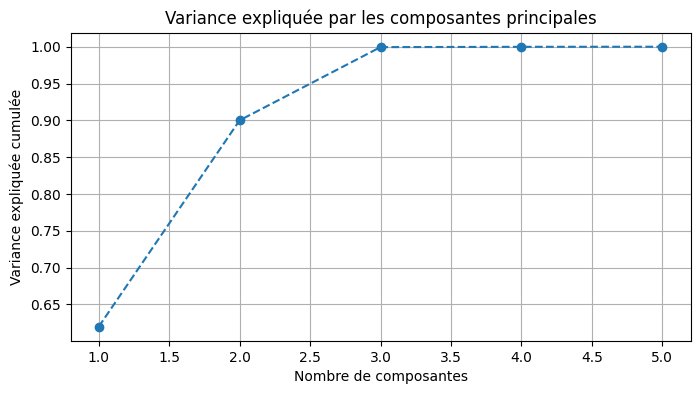

In [43]:
# 📊 Affichage de la variance expliquée par l'ACP
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par les composantes principales")
plt.grid()
plt.show()


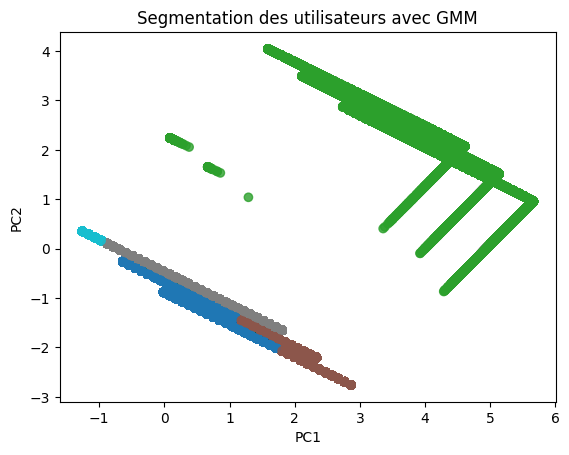

In [44]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_cluster)

plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=labels_gmm, cmap='tab10', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Segmentation des utilisateurs avec GMM")
plt.show()


📊 Détermination du nombre optimal de clusters...
🔍 Test avec k=2 commencé
✅ Test avec k=2 terminé
🔍 Test avec k=3 commencé
✅ Test avec k=3 terminé
🔍 Test avec k=4 commencé
✅ Test avec k=4 terminé
🔍 Test avec k=5 commencé
✅ Test avec k=5 terminé
🔍 Test avec k=6 commencé
✅ Test avec k=6 terminé
🔍 Test avec k=7 commencé
✅ Test avec k=7 terminé
🔍 Test avec k=8 commencé
✅ Test avec k=8 terminé
🔍 Test avec k=9 commencé
✅ Test avec k=9 terminé
🔍 Test avec k=10 commencé
✅ Test avec k=10 terminé


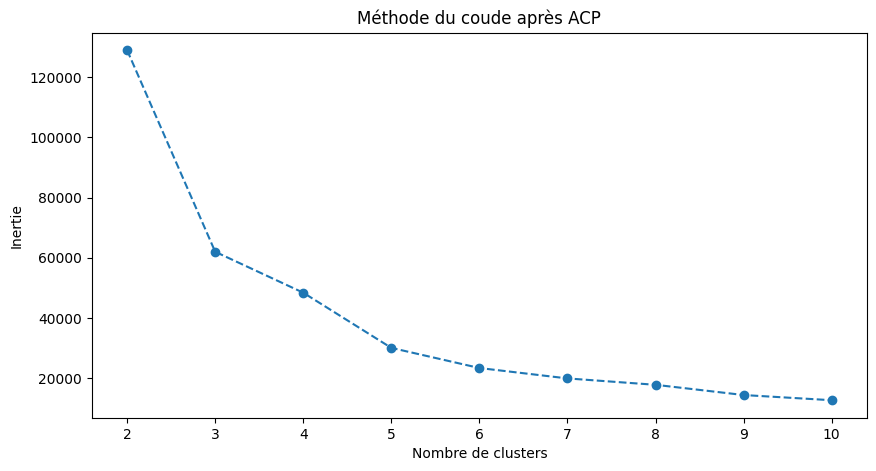

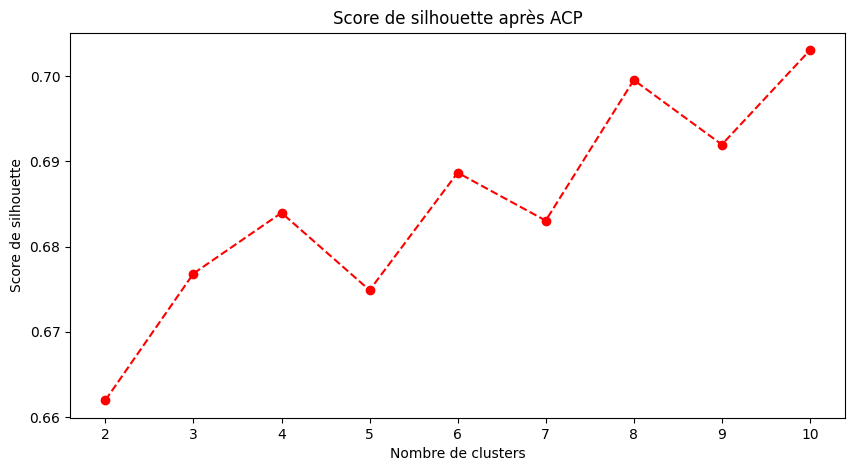

In [36]:
# 📌 Sélection des n premières composantes pour le clustering (on prend 2 pour accélérer)
n_components = 3  
X_cluster = X_pca[:, :n_components]  

# 📉 Échantillonnage : prendre 50 000 lignes aléatoires pour accélérer
sample_size = min(50000, X_cluster.shape[0])
X_sample = X_cluster[np.random.choice(X_cluster.shape[0], sample_size, replace=False)]

# 🔍 Détermination du nombre optimal de clusters avec la méthode du coude
print("📊 Détermination du nombre optimal de clusters...")
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    print(f"🔍 Test avec k={k} commencé")
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=5000, max_iter=20, n_init=1)
    labels = kmeans.fit_predict(X_sample)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, labels))
    
    print(f"✅ Test avec k={k} terminé")

# 💚 Tracer la courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude après ACP")
plt.show()

# 📈 Tracer la courbe des scores de silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.title("Score de silhouette après ACP")
plt.show()

📌 Nombre optimal de clusters choisi : 5
🚀 Clustering avec K=5...
✅ Clustering terminé !


c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


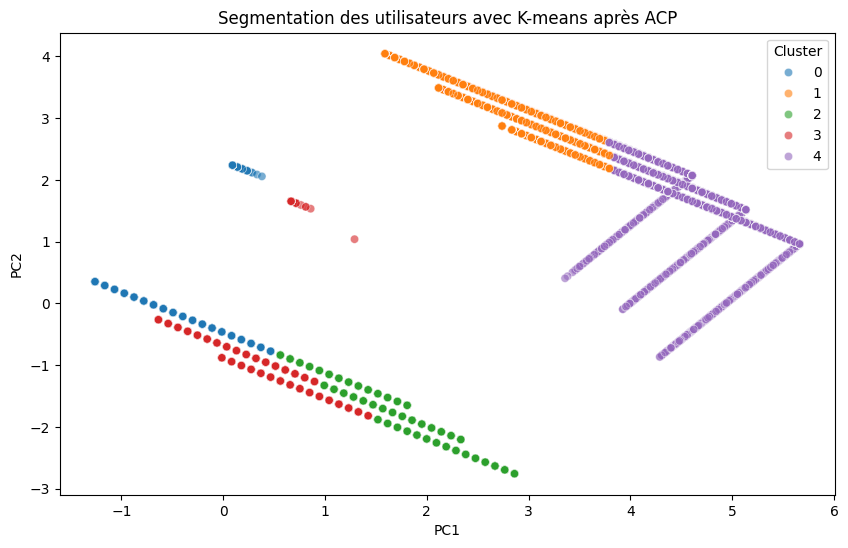

In [37]:
# 👉 Choisir le k optimal selon l'analyse visuelle
optimal_k = 5
print(f"📌 Nombre optimal de clusters choisi : {optimal_k}")

# 📌 Application du K-means avec k optimal
print(f"🚀 Clustering avec K={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_cluster)
print("✅ Clustering terminé !")

# 📈 Visualisation des clusters dans l'espace des 2 premières composantes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_cluster[:, 0], y=X_cluster[:, 1], hue=df["cluster"], palette="tab10", alpha=0.6)
plt.title("Segmentation des utilisateurs avec K-means après ACP")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

🔍 Application de HDBSCAN...


c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ HDBSCAN terminé !


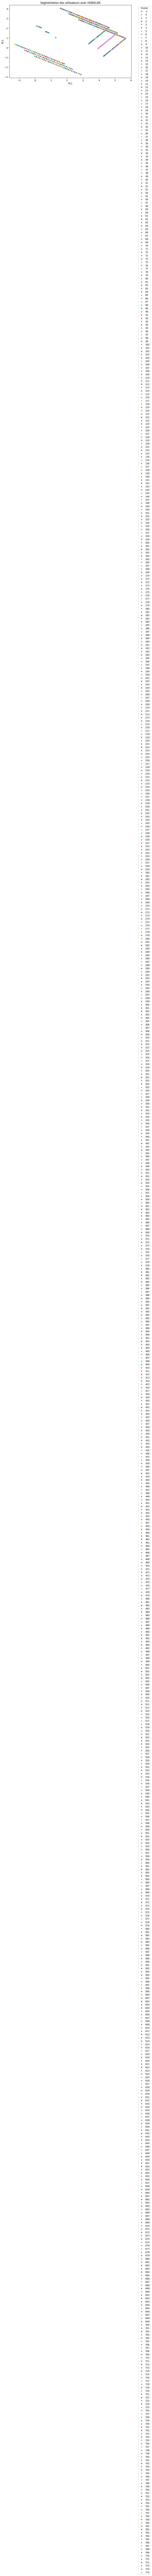

In [42]:
# 📌 Paramètres optimisés pour HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,  # Taille minimale pour un cluster
    min_samples=10,       # Nombre min de voisins pour un point
    metric="euclidean",   # Distance euclidienne
    cluster_selection_method='eom'  # Meilleure méthode de sélection
)

print("🔍 Application de HDBSCAN...")
labels = clusterer.fit_predict(X_cluster)
print("✅ HDBSCAN terminé !")

# 🔹 Ajout des labels aux données
X_cluster_with_labels = np.column_stack((X_cluster, labels))

# 📊 Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_cluster[:, 0], y=X_cluster[:, 1], hue=labels, palette="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Segmentation des utilisateurs avec HDBSCAN")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()
